<a href="https://colab.research.google.com/github/e-olang/Computer-Vision/blob/main/Image%20Generation/image_generation_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/Image Generation

/content/drive/MyDrive/Colab Notebooks/Image Generation


In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/Image Generation'

-----

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
fashion_data = keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_val, y_val) = fashion_data
x_train.shape, x_val.shape

4431872/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [5]:
del y_train, y_val

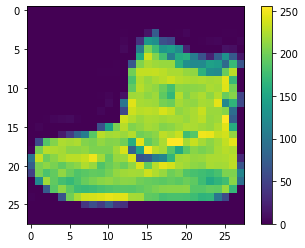

In [6]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
plt.colorbar()
plt.show()

In [7]:
# merge the train and val datasets since this is a self supervised approach

data = tf.concat([x_train, x_val], axis = 0)

# add dimensions 2d to 3d
data = tf.expand_dims(data, -1)

# scale images
data = tf.cast(data, tf.float32)
data = data / 255.0

In [8]:
# Building the VAE Architecture
class Sampling(layers.Layer):

    def call(self, inputs):
        mean, logvar = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        eps = tf.keras.backend.random_normal(shape = (batch, dim))
        return mean + tf.exp(0.5 * logvar) * eps

In [9]:
# Build an encoder that takes an image as input and outputs sampling representation as output.
encoder_inputs = keras.Input(shape = (28,28,1))
x = layers.Conv2D(32, 3, activation = "relu", strides = 2, padding = "same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation = "relu", strides = 2, padding = "same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation = "relu")(x)
mean = layers.Dense(2, name = "z_mean")(x)
logvar = layers.Dense(2, name = "z_log_var")(x)
z = Sampling()([mean, logvar])
encoder = keras.Model(encoder_inputs, [mean, logvar, z], name = "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

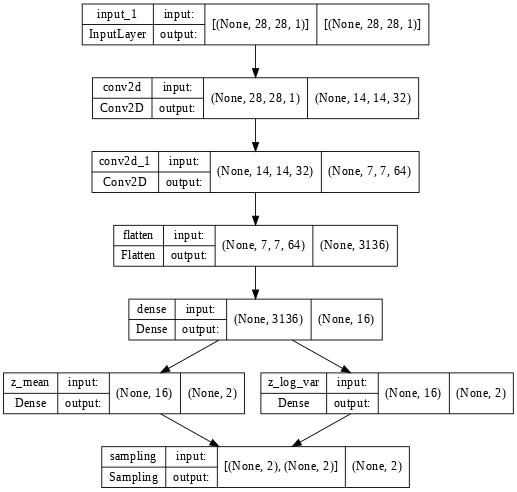

In [10]:
keras.utils.plot_model(encoder, show_shapes=True, dpi=64)

In [11]:
# Build a decoder that takes the inputs from the encoder, performs transpose convolution, and develops a synthetic image of size 14 by 14.

latent_inputs = keras.Input(shape = (2, ))
x = layers.Dense(7 * 7* 64, activation ="relu")(latent_inputs)

# form 7 by 7 feature map
x = layers.Reshape((7, 7, 64))(x)

# form 14 by 14 feature map
x = layers.Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding = "same")(x)

# form 28 by 28 feature map
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

# form the sigmoid output -single image
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

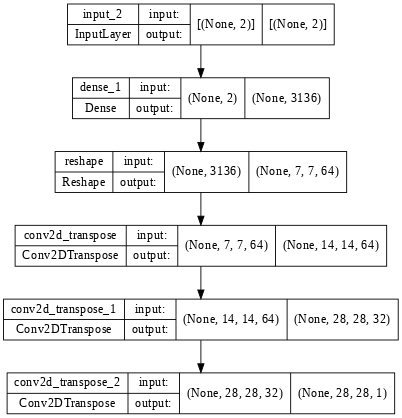

In [12]:
keras.utils.plot_model(decoder, show_shapes = True, dpi = 64)

In [13]:
# Training

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, logvar, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        } 

In [14]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(data, epochs=30, batch_size=128) 

Epoch 1/30
547/547 [==============================] - 18s 9ms/step - loss: 374.2139 - reconstruction_loss: 313.3003 - kl_loss: 6.6290
Epoch 2/30
547/547 [==============================] - 5s 9ms/step - loss: 278.3342 - reconstruction_loss: 269.8632 - kl_loss: 6.5038
Epoch 3/30
547/547 [==============================] - 5s 9ms/step - loss: 273.4674 - reconstruction_loss: 266.0574 - kl_loss: 6.2734
Epoch 4/30
547/547 [==============================] - 5s 9ms/step - loss: 270.9895 - reconstruction_loss: 264.3338 - kl_loss: 6.1678
Epoch 5/30
547/547 [==============================] - 5s 9ms/step - loss: 269.6664 - reconstruction_loss: 262.9662 - kl_loss: 6.1386
Epoch 6/30
547/547 [==============================] - 5s 9ms/step - loss: 268.7477 - reconstruction_loss: 261.9076 - kl_loss: 6.1255
Epoch 7/30
547/547 [==============================] - 5s 9ms/step - loss: 267.1248 - reconstruction_loss: 261.2567 - kl_loss: 6.1306
Epoch 8/30
547/547 [==============================] - 5s 9ms/step - 

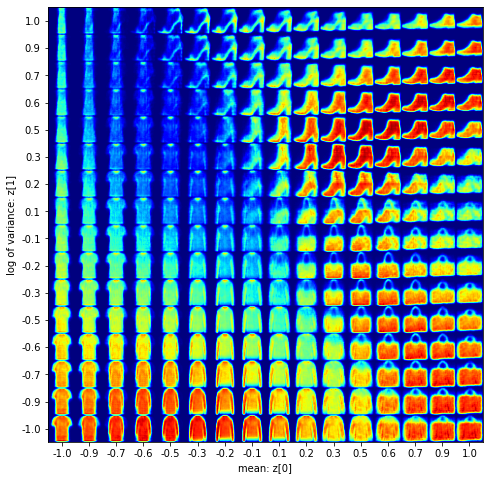

In [16]:
def plot_latent_space(vae, n=16, figsize=8):
    # display a n*n 2D manifold of fashion data
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean: z[0]")
    plt.ylabel("log of variance: z[1]")
    plt.imshow(figure, cmap="jet")
    plt.show()
plot_latent_space(vae) 

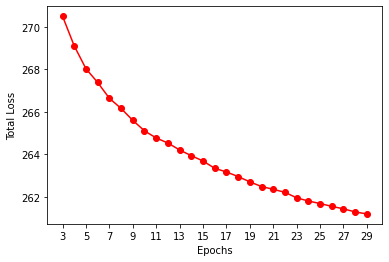

In [17]:
loss = history.history['loss']
# plot loss from 4rd epoch onwards
index = np.arange(3, 30)
plt.plot(index, loss[3:], 'o-r')
plt.xticks(np.arange(3, 30, 2))
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.show() 